In [1]:
!pip install -U -q pip
!pip install -U -q 'ket-lang[full]>=0.8.3,<0.9'

from IPython.display import display

import plotly.io as pio

pio.renderers.default = "iframe"

# Programacão Quântica com Ket

Neste capítulo, exploraremos a plataforma de programação quântica Ket, um projeto de código aberto que permite desenvolver e testar aplicações quânticas.

## Introdução

### Instalação

Se você estiver executando esta página com <i class="fas fa-rocket"></i> **Live Code**, o Ket será instalado automaticamente quando o ambiente de execução for carregado. Caso esteja utilizando um Notebook <i class="fas fa-download"></i> baixado desta página ou acessando via <i class="fas fa-rocket"></i> **Binder/Colab**, os comandos de instalação estarão na primeira célula do notebook.

Para integrar o Ket em um projeto externo, instale-o via PyPI utilizando o seguinte comando:

```bash
pip install -U pip
pip install ket-lang
```

### Documentação

A documentação completa da API do Ket está disponível em [quantumket.org](https://quantumket.org). Caso tenha dúvidas sobre alguma função ou queira conhecer as funcionalidades disponíveis, recomendamos a consulta à documentação. Além disso, todas as classes, métodos e funções referenciados nesta página possuem links diretos para suas respectivas documentações. Sempre que encontrar um novo elemento, sugerimos a leitura do material correspondente para uma compreensão mais detalhada.

### Importando o Ket

A célula abaixo importa todas as funcionalidades do Ket, permitindo o acesso direto a todas as suas classes e funções:


In [2]:
from ket import *
from ket import lib as qulib

## Processo Quântico  

Por trás de toda execução quântica no Ket, há um processo quântico, uma instância da classe {class}`~ket.base.Process`. Ele é responsável por gerenciar desde a alocação dos qubits até a compilação do código quântico.  

Para iniciar uma execução quântica, é necessário instanciar um {class}`~ket.base.Process`. Existem diversas configurações que podem ser ajustadas, mas um bom ponto de partida é utilizar o construtor padrão. Se nenhum argumento for passado, o simulador **KBW Sparse** será utilizado com **32 qubits**, e a **execução dinâmica** (*live execution*) será ativada por padrão.  

Exploraremos o significado de cada parâmetro mais adiante neste capítulo.  

Abaixo, temos a criação de um processo:

In [3]:
processo = Process()

### Alocação de Qubits  

Na computação quântica, a unidade básica de computação é o **qubit**. No Ket, o elemento fundamental da programação é a classe {class}`~ket.base.Quant`, que nada mais é do que uma lista de qubits. Toda operação quântica, seja a aplicação de portas lógicas ou medições, é realizada sobre um objeto do tipo {class}`~ket.base.Quant`.  

Em breve, veremos como aplicar essas operações nos qubits, mas primeiro, vamos entender como instanciá-los.  

No Ket, um qubit está sempre associado a um {class}`~ket.base.Process`. Para acessar qubits, é necessário fazer uma chamada de alocação para o processo quântico, utilizando o método {meth}`~ket.base.Process.alloc`. O resultado dessa alocação é uma lista de qubits encapsulada em um objeto {class}`~ket.base.Quant`. Mesmo que apenas um qubit seja alocado, ele ainda estará dentro de um {class}`~ket.base.Quant`.  

Em muitos casos, um processo quântico é criado apenas para alocar qubits. No entanto, ele também armazena **metadados** ({meth}`~ket.base.Process.get_metadata`), que podem ser úteis para experimentos e análises.  

```{note}  
Dentro de um {class}`~ket.base.Quant`, os qubits são referências opacas. Isso significa que eles não armazenam diretamente a informação quântica, mas sim uma referência a essa informação dentro do computador quântico. Além disso, os qubits expostos ao programador são **qubits lógicos**, que, após o processo de compilação, serão mapeados para **qubits físicos** no hardware quântico.  
```  

A classe {class}`~ket.base.Quant` funciona como uma lista de qubits, e suas instâncias suportam as operações padrão do Python para listas. Por exemplo, é possível:  
- **Indexar** qubits usando colchetes `[]`.  
- **Concatenar** dois objetos {class}`~ket.base.Quant` utilizando o operador de adição `+`.  

Abaixo, temos exemplos de alocação de qubits:

In [4]:
# Instanciando um novo processo quântico
processo = Process()

# Alocação de um único qubit
qubits = processo.alloc()

# Alocação de dois qubits
par_qubit = processo.alloc(2)

# Acessando os qubits individualmente
primeiro_qubit = par_qubit[0]
segundo_qubit = par_qubit[1]

# Concatenando os qubits
qubits_concatenados = qubits + primeiro_qubit + segundo_qubit

# Mostrando os qubits alocados e concatenados
print("Qubit alocado:", qubits)
print("Par de qubits alocados:", par_qubit)
print("Qubits concatenados:", qubits_concatenados)

Qubit alocado: <Ket 'Quant' [0] pid=0x7f50c02d39d0>
Par de qubits alocados: <Ket 'Quant' [1, 2] pid=0x7f50c02d39d0>
Qubits concatenados: <Ket 'Quant' [0, 1, 2] pid=0x7f50c02d39d0>


Ao imprimir na tela uma variável do tipo {class}`~ket.base.Quant`, podemos observar uma lista com os índices dos qubits que esse objeto referencia.  

É importante notar que, ao indexarmos elementos em um {class}`~ket.base.Quant`, mesmo que estejamos acessando apenas um qubit, o retorno sempre será outro objeto do tipo {class}`~ket.base.Quant`. No Ket, os qubits estão sempre encapsulados em instâncias dessa classe.  

## Portas Lógicas Quânticas  

O Ket oferece um conjunto universal de portas lógicas quânticas, permitindo a descrição de qualquer computação quântica. Todas as portas implementadas no Ket estão disponíveis no módulo {mod}`~ket.gates`. Na documentação, é possível visualizar tanto a representação matricial das portas quanto seus efeitos.  

### Portas de 1 Qubit  

As portas quânticas são aplicadas diretamente a qubits encapsulados em objetos {class}`~ket.base.Quant`. No Ket, os qubits são implementados como referências opacas, garantindo que a aplicação de portas quânticas não tenha efeitos colaterais no estado clássico do sistema, afetando apenas o estado quântico.  

As portas implementadas no Ket seguem a convenção de nomes em letras maiúsculas. Por exemplo, as **portas de Pauli** incluem {func}`~ket.gates.X`, {func}`~ket.gates.Y` e {func}`~ket.gates.Z`, enquanto a **porta de Hadamard** é representada por {func}`~ket.gates.H`.  

#### Portas de Pauli e de Hadamard  

As portas de Pauli e a porta de Hadamard são fundamentais para muitos algoritmos quânticos. As portas de Pauli realizam rotações de 180º nos eixos X, Y e Z da [esfera de Bloch](esfera-de-bloch). No entanto, essas portas, por si só, não são suficientes para gerar **superposição**. Para isso, utilizamos a porta de Hadamard, que transforma um qubit do estado {math}`\ket{0}` ou {math}`\ket{1}` para o estado de superposição:  

```{math}
\frac{1}{\sqrt{2}}(\ket{0} \pm \ket{1})
```

```{tip}  
Para visualizar o efeito das portas, podemos utilizar o comando:  
`dump(<qubits>).sphere()`  
```  

A seguir, apresentamos um exemplo que demonstra a aplicação das **portas de Pauli** e da **porta de Hadamard**. Recomendamos que você execute este código e experimente modificar a aplicação das portas para entender melhor seus efeitos:  

In [5]:
# Instanciando um novo do processo quântico
processo = Process()

# Alocação de um qubit
qubits = processo.alloc()

X(qubits)  # Porta de Pauli X
Y(qubits)  # Porta de Pauli Y
Z(qubits)  # Porta de Pauli Z
H(qubits)  # Porta de Hadamard

dump(qubits).sphere()  # Mostra o Bloch Sphere

#### Portas Parametrizadas  

Além das portas de Pauli e da porta de Hadamard, o Ket também oferece **portas de rotação** e a **porta de fase**, que desempenham um papel essencial na construção de algoritmos quânticos.  

As portas de rotação, como {func}`~ket.gates.RX`, {func}`~ket.gates.RY` e {func}`~ket.gates.RZ`, realizam rotações controladas em torno dos eixos X, Y e Z, respectivamente. Essas portas permitem manipular o estado de um qubit de forma precisa e controlada.  

Já a porta de fase, representada por {func}`~ket.gates.PHASE`, aplica uma fase ao estado do qubit. Essas portas são chamadas de portas parametrizadas, pois recebem um parâmetro clássico (um número real, `float`), que controla a operação aplicada.  

A porta {func}`~ket.gates.RZ` e a {func}`~ket.gates.PHASE` são equivalentes em termos de fase global, ou seja, ao analisarmos seu efeito na esfera de Bloch, não conseguimos distingui-las. No entanto, quando usadas em operações controladas, a fase global pode gerar diferenças no estado quântico.  

A seguir, apresentamos um exemplo que demonstra a aplicação das portas parametrizadas. Recomendamos que você execute este código e experimente modificar os parâmetros das portas para compreender melhor seus efeitos:  

In [6]:
# Instanciando um novo do processo quântico
processo = Process()

# Alocação de um qubit
qubits = processo.alloc()

# Aplicação das portas parametrizadas
RX(0.5, qubits)  # Porta de rotação Rx com ângulo de 0.5 radianos
RY(0.2, qubits)  # Porta de rotação Ry com ângulo de 0.2 radianos
RZ(2.3, qubits)  # Porta de rotação Rz com ângulo de 2.3 radianos
PHASE(0.2, qubits)  # Porta de fase com ângulo de 0.2 radianos

dump(qubits).sphere()  # Mostra o Bloch Sphere

#### Concatenando Portas Quânticas  

Ao listar a aplicação de portas lógicas quânticas linha por linha, podemos inflar desnecessariamente o número de linhas de código, tornando o programa menos legível e mais difícil de entender. Para evitar esse problema, uma prática útil na implementação de algoritmos quânticos é a concatenação de portas lógicas, que permite expressar operações de forma mais concisa.  

No Ket, existem duas maneiras de concatenar portas lógicas.  

##### Encadeamento de chamadas de função

Essa abordagem é recomendada quando o número de portas encadeadas não é muito grande. No entanto, o uso excessivo de parênteses pode comprometer a legibilidade do código. Como cada porta implementada no Ket retorna o próprio objeto {class}`~ket.base.Quant` passado como parâmetro, podemos encadear as operações conforme mostrado no exemplo abaixo:  

In [7]:
# Instanciando um novo do processo quântico
processo = Process()

# Alocação de um qubit
qubits = processo.alloc()

H(Z(H(qubits)))  # Equivalente a:
# H(qubit)
# Z(qubit)
# H(qubit)

dump(qubits).sphere()  # Mostra o Bloch Sphere

##### Concatenação de portas

A segunda opção é utilizar a função {func}`~ket.operations.cat`, que permite criar uma nova porta representando a concatenação das portas passadas como argumento.  

Essa abordagem é especialmente útil em situações onde precisamos armazenar ou reutilizar uma sequência específica de operações quânticas. Ao criar uma nova porta quântica com {func}`~ket.operations.cat`, podemos encapsular essa sequência de operações em uma única entidade. Isso torna o código mais modular, facilita a reutilização de blocos de operações e melhora a organização do programa.  

In [8]:
# Instanciando um novo do processo quântico
processo = Process()

# Alocação de um qubit
qubits = processo.alloc()

porta_X = cat(H, Z, H)  # Concatena portas

porta_X(qubits)

dump(qubits).sphere()  # Mostra o Bloch Sphere

Para concatenar portas parametrizadas usando a função {func}`~ket.operations.cat`, basta fornecer o argumento clássico correspondente. Quando apenas esse argumento é passado, a função cria uma nova porta com o parâmetro já aplicado.

In [9]:
from math import pi

# Instanciando um novo do processo quântico
processo = Process()

# Alocação de um qubit
qubits = processo.alloc()

porta_H = cat(RY(pi / 2), RX(pi))
porta_X = cat(porta_H, RZ(pi), porta_H)

porta_X(qubits)

dump(qubits).sphere()  # Mostra o Bloch Sphere

### Portas de 2 Qubits  

Para explorar todo o potencial da computação quântica, é necessário utilizar o **entrelaçamento** quântico, que requer o uso de portas que operam em dois qubits, como a {func}`~ket.gates.CNOT`. Juntas com as portas de 1 qubit apresentadas anteriormente, a porta {func}`~ket.gates.CNOT` forma um conjunto universal de portas lógicas quânticas. Além disso, o Ket oferece outras portas para facilitar a implementação de algoritmos quânticos, como {func}`~ket.gates.SWAP`, {func}`~ket.gates.RXX`, {func}`~ket.gates.RYY` e {func}`~ket.gates.RZZ`.  

Para exemplificar o uso de portas de 2 qubits, vamos criar um **estado de Bell**:  

$$
\frac{1}{\sqrt{2}}(\ket{00} + \ket{11})
$$

Para isso, podemos utilizar a porta {func}`~ket.gates.CNOT`.  

```{tip}  
Como a geração de entrelaçamento requer dois ou mais qubits, não podemos mais usar a `dump(<qubits>).sphere()`. No entanto, podemos utilizar a função `dump(qubits).show()` para imprimir o estado quântico com a combinação linear dos estados da base computacional.  
```  

In [10]:
# Instanciando um novo  processo quântico
p = Process()

# Alocação de dois qubits
a, b = p.alloc(2)

# Aplicando a porta Hadamard em 'a' para criar superposição
H(a)

# Aplicando a porta CNOT controlada por 'a' e alvo 'b'
# para criar o estado de Bell
CNOT(a, b)

# Imprimindo o estado do sistema
dump(a + b).show()

<IPython.core.display.Math object>

Assim como ocorre com as portas de 1 qubit, também é possível oncatenar operações com portas de 2 qubits, como exemplificado no código abaixo, que prepara o estado de Bell:

In [11]:
# Instanciando um novo processo quântico
p = Process()

# Alocação de dois qubits
a, b = p.alloc(2)

# Aplicando a porta CNOT controlada por 'a' e alvo 'b'
# após a aplicação da porta Hadamard em 'a'
CNOT(H(a), b)

# Imprimindo o estado do sistema
dump(a + b).show()

<IPython.core.display.Math object>

#### Produto Tensorial de Portas  

É possível criar portas de múltiplos qubits utilizando o produto tensorial com a função {func}`~ket.operations.kron`. Essa função aceita múltiplas portas como argumentos e gera uma nova porta lógica que opera em múltiplos qubits.  

Podemos usar a função {func}`~ket.operations.kron` em conjunto com a função {func}`~ket.operations.cat` para criar uma nova porta de dois qubits que prepara um estado de Bell, como no exemplo abaixo:  

In [12]:
# Instanciando um novo processo quântico
p = Process()

# Alocação de dois qubits
a, b = p.alloc(2)

# Concatenando as operações para preparar o estado de Bell
bell = cat(kron(H, I), CNOT)
bell(a, b)

# Imprimindo o estado do sistema
dump(a + b).show()

<IPython.core.display.Math object>

Neste exemplo, a operação `kron(H, I)` cria uma porta de dois qubits, aplicando a operação Hadamard em `a` e a operação identidade em `b`. Em seguida, a operação `CNOT` é aplicada como uma operação controlada entre `a` e `b`. Isso resulta na preparação do estado de Bell nos qubits `a` e `b`.

Aqui está o seu texto corrigido e aprimorado:


Como `bell` é considerada uma nova porta lógica quântica, podemos usar a função {func}`~ket.lib.draw` para visualizar o circuito quântico que ela representa.

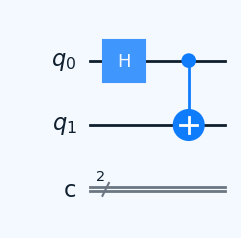

In [13]:
qulib.draw(gate=bell, num_qubits=(1, 1), output="mpl")

## Instruções Quânticas

Além das portas lógicas quânticas já apresentadas, o Ket oferece instruções que aproveitam a especificidade da computação quântica para facilitar a programação.

### Operações Controladas

É comum criar portas lógicas quânticas de múltiplos qubits adicionando qubits de controle a portas já existentes. No Libket, a biblioteca de tempo de execução do Ket, apenas portas de 1 qubit são implementadas, mas elas permitem a adição de controles. Por exemplo, podemos gerar a porta {func}`~ket.gates.CNOT` a partir da porta {func}`~ket.gates.X`. No Ket, as operações controladas são aplicadas somente se todos os qubits de controle estiverem no estado $\ket{1}$.

Existem duas maneiras de realizar operações controladas no Ket:  
1. Usando a instrução `with` {func}`~ket.operations.control` para criar um contexto controlado.  
2. Utilizando a função {func}`~ket.operations.ctrl` para criar uma nova porta controlada.

Abaixo, apresentamos exemplos de como criar as portas CNOT, Toffoli (CCNOT), SWAP e Fredkin (CSWAP) a partir da porta {func}`~ket.gates.X`.

No Ket, qualquer função Python que aceite qubits como argumento e não realize nenhuma medida ou alocação de qubits pode ser considerada uma porta lógica quântica, o que facilita a criação de novas portas. Além disso, podemos usar a função {func}`~ket.lib.draw` para visualizar a porta gerada.

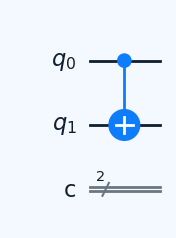

In [14]:
def meu_cnot(a, b):
    ctrl(a, X)(b)


qulib.draw(gate=meu_cnot, num_qubits=(1, 1), output="mpl")

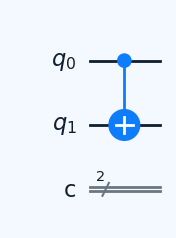

In [15]:
def meu_cnot2(a, b):
    with control(a):
        X(b)


qulib.draw(gate=meu_cnot2, num_qubits=(1, 1), output="mpl")

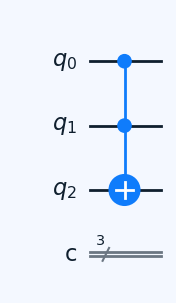

In [16]:
def toffoli(a, b, c):
    ctrl(a + b, X)(c)


qulib.draw(gate=toffoli, num_qubits=(1, 1, 1), output="mpl")

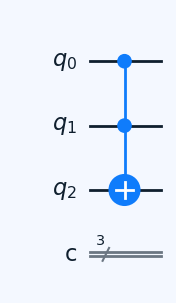

In [17]:
def toffoli2(a, b, c):
    with control(a + b):
        X(c)


qulib.draw(gate=toffoli2, num_qubits=(1, 1, 1), output="mpl")

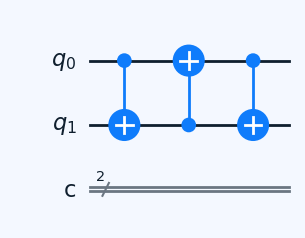

In [18]:
def meu_swap(a, b):
    meu_cnot(a, b)
    meu_cnot(b, a)
    meu_cnot(a, b)


qulib.draw(gate=meu_swap, num_qubits=(1, 1), output="mpl")

```{tip}  
Embora a implementação de `meu_swap` esteja correta, ela não aproveita uma otimização introduzida pelo uso de `with` {func}`~ket.operations.around`, que será abordada mais adiante neste capítulo.  

A ausência dessa otimização pode ser observada no circuito da porta Fredkin abaixo, que não está em sua forma otimizada.  
```

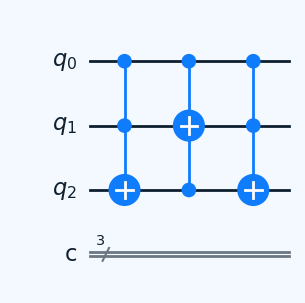

In [19]:
def fredkin(a, b, c):
    with control(a):
        meu_swap(b, c)


qulib.draw(gate=fredkin, num_qubits=(1, 1, 1), output="mpl")

### Exercício: Implementando o Estado GHZ

Neste exercício, o objetivo é usar a função {func}`~ket.operations.ctrl` para implementar uma porta quântica que prepara o estado GHZ de $n$ qubits.

O estado GHZ é definido como:

$$
\begin{aligned}
\ket{\text{GHZ}} &= \frac{1}{\sqrt{2}}(\ket{0}^{\otimes n} + \ket{1}^{\otimes n})  \\
&= \frac{1}{\sqrt{2}}(\ket{0} \otimes \ket{0} \otimes \cdots \otimes \ket{0} + \ket{1} \otimes \ket{1} \otimes \cdots \otimes \ket{1})
\end{aligned}
$$

Para implementar essa funcionalidade, você precisa completar a função `ghz` que recebe um objeto {class}`~ket.base.Quant` representando os qubits e realiza as operações necessárias para preparar o estado GHZ.

In [20]:
def ghz(qubits: Quant):
    # Implemente aqui a função ghz usando a função ctrl
    ...


n = 10

processo = Process()
qubits = processo.alloc(n)

ghz(qubits)

dump(qubits).show()

<IPython.core.display.Math object>


A função {func}`~ket.operations.ctrl` recebe dois argumentos: um objeto do tipo {class}`~ket.base.Quant` com os qubits de controle (sendo possível utilizar múltiplos qubits de controle) e uma função que atua como uma porta lógica quântica. É importante ressaltar que a função {func}`~ket.operations.ctrl` não está limitada a adicionar qubits de controle apenas às portas quânticas disponíveis no módulo {mod}`~ket.gates`, mas pode adicionar qubits de controle a qualquer função. Por exemplo, podemos implementar uma porta de Bell e adicionar qubits de controle a ela como no código abaixo.

In [21]:
def bell(a: Quant, b: Quant) -> tuple[Quant, Quant]:
    """
    Implementa a preparação do estado de Bell entre dois qubits.

    Parâmetros:
        a (Quant): O primeiro qubit.
        b (Quant): O segundo qubit.

    Retorna:
        tuple[Quant, Quant]: Os qubits de entrada a e b.

    Observação:
        Por convenção, as portas implementadas no Ket retornam os Quants de
        entrada para facilitar a concatenação de portas.
        No entanto, isso não é necessário.
    """
    H(a)  # Aplica a porta Hadamard ao primeiro qubit
    CNOT(a, b)  # Aplica a porta CNOT controlada pelo primeiro qubit 'a' e alvo 'b'
    return a, b  # Retorna os qubits de entrada 'a' e 'b'


# Instancia um novo processo quântico
processo = Process()

# Aloca três qubits 'a', 'b' e 'c'
a, b, c = processo.alloc(3)

# Aplica uma operação controlada com o qubit 'a' e a função bell aos qubits 'b' e 'c'
ctrl(H(a), bell)(b, c)

# Imprime o estado do sistema
dump(a + b + c).show()

<IPython.core.display.Math object>

### Operações Inversas

Com exceção das operações de medida, toda computação quântica é reversível, ou seja, para todas as portas lógicas quânticas existe uma operação inversa correspondente. Isso é explorado em diversos algoritmos quânticos. Por exemplo, o algoritmo de estimação de fase requer uma operação de transformada de Fourier quântica inversa. No entanto, podemos implementar a transformada normalmente no Ket e usar a função {func}`~ket.operations.adj` para criar a transformada inversa. Podemos ver isso em ação no código abaixo.

:::{tip}
O código abaixo apresenta algumas operações que ainda não foram vistas neste capítulo. Não se preocupe em entender o código, o objetivo é apenas ilustrar o uso da função {func}`~ket.operations.adj`.
:::

In [22]:
from math import pi


def qft(qubits: Quant, invert: bool = True):
    if len(qubits) == 1:
        H(qubits)
    else:
        *init, last = qubits
        H(last)
        for i, ctrl_qubit in enumerate(reversed(init)):
            ctrl(ctrl_qubit, PHASE(pi / 2 ** (i + 1)))(last)
        qft(init, invert=False)
    if invert:
        size = len(qubits)
        for i in range(size // 2):
            SWAP(qubits[i], qubits[size - i - 1])


def estimador_de_fase(oraculo, precisão: int) -> float:
    assert precisão <= 20, "o tempo de computação pode ser muito grande"
    p = Process(simulator="dense", num_qubits=precisão + 1)
    ctr = H(p.alloc(precisão))
    tgr = X(p.alloc())
    for i, c in enumerate(ctr):
        ctrl(c, oraculo)(i, tgr)

    adj(qft)(ctr)  # <- chada da transformada de Fourier quântica inversa

    return measure(reversed(ctr)).value / 2**precisão


fase = pi

estimador_de_fase(
    oraculo=lambda i, tgr: PHASE(2 * pi * (fase / 10) * 2**i, tgr),
    precisão=18,
) * 10

3.1415939331054688


Para realizar operações inversas, uma abordagem alternativa é empregar a instrução `with` {func}`~ket.operations.inverse`. Esta instrução cria um contexto onde as operações são executadas na ordem usual do Python, mas as portas lógicas quânticas são aplicadas de maneira inversa no estado quântico. Abaixo está um exemplo que demonstra o uso dessa instrução. Note que é necessário fornecer o {class}`~ket.base.Process` onde as operações inversas serão aplicadas.


In [23]:
processo = Process()

a, b = processo.alloc(2)

print("Estado inicial:")
display(dump(a + b).show())

# Prepara o estado de Bell
H(a)
CNOT(a, b)

print("Estado após a preparação:")
display(dump(a + b).show())

# Invertendo a preparação do estado de Bell
with inverse(processo):
    H(a)
    CNOT(a, b)

print("Estado após a inversão da preparação:")
dump(a + b).show()

Estado inicial:


<IPython.core.display.Math object>

Estado após a preparação:


<IPython.core.display.Math object>

Estado após a inversão da preparação:


<IPython.core.display.Math object>

### Operações $UVU^\dagger$

Uma construção comum em algoritmos quânticos é aplicar uma operação $U$ em torno de outra operação $V$, seguida pela operação inversa $U^\dagger$. Essa sequência de operações é representada matematicamente como $UVU^\dagger$.

Um exemplo do uso desse tipo de construção está na implementação do difusor do algoritmo de Grover. Nele, uma operação controlada é envolta por portas de Hadamard. Aqui, as portas $U$ são as portas de Hadamard, e é importante observar que a Hadamard é sua própria inversa. A porta controlada é representada pela porta $V$.

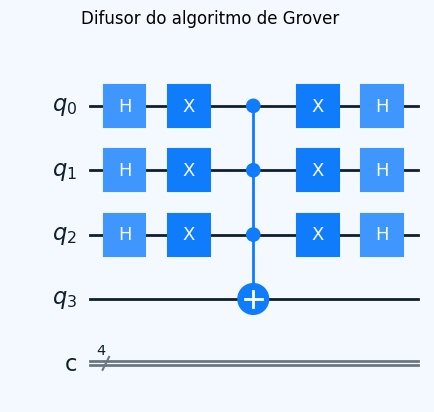

In [24]:
def difusor(qubits: Quant, auxiliar: Quant):
    with around(cat(H, X), qubits):
        ctrl(qubits, X)(auxiliar)


fig = qulib.draw(gate=difusor, num_qubits=(3, 1), output="mpl")
fig.suptitle("Difusor do algoritmo de Grover")
fig

Para facilitar essa construção no Ket, a instrução `with` {func}`~ket.operations.around` é oferecida. No exemplo acima, implementamos o difusor de Grover usando essa instrução.

A título de comparação, a seguir está implementado o difusor de Grover sem usar a instrução `with` {func}`~ket.operations.around`. Além da redução do número de linhas, o uso de `with` {func}`~ket.operations.around` torna o código mais legível e menos propenso a erros, proporcionando uma implementação mais eficiente.

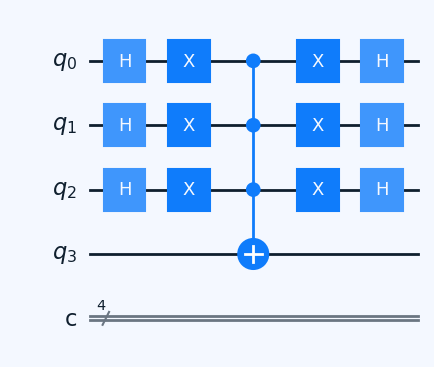

In [25]:
def difusor_2(qubits: Quant, auxiliar: Quant):
    H(qubits)
    X(qubits)
    ctrl(qubits, X)(auxiliar)
    X(qubits)
    H(qubits)


qulib.draw(gate=difusor_2, num_qubits=(3, 1), output="mpl")

Além de facilitar a construção de algumas operações quânticas, a estrutura `with` {func}`~ket.operations.around` também permite [reduzir o número de qubits de controle em certas operações](https://arxiv.org/abs/2406.05581).  

No exemplo abaixo, utilizamos `with` {func}`~ket.operations.around` para definir uma porta SWAP e, em seguida, empregamos essa mesma porta para implementar uma porta de Fredkin, que é essencialmente uma versão controlada da SWAP.  

Note que, no circuito abaixo, há menos qubits de controle em comparação com o exemplo anterior da porta de Fredkin.


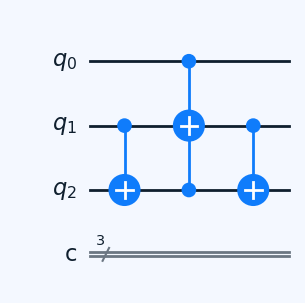

In [26]:
def meu_swap_op(a, b):
    with around(CNOT, a, b):
        CNOT(b, a)


def fredkin_op(a, b, c):
    ctrl(a, meu_swap_op)(b, c)


qulib.draw(gate=fredkin_op, num_qubits=(1, 1, 1), output="mpl")

#### Alterando o Estado de Controle

Por padrão, as operações quânticas são aplicadas apenas quando os qubits de controle estão no estado $\ket{1}$. No entanto, em certos casos, precisamos alterar esse comportamento. Para isso, podemos usar a função {func}`ket.lib.flip_to_control` em conjunto com a instrução `with` {func}`~ket.operations.around` para mudar o estado de controle de uma operação quântica. 

O exemplo abaixo ilustra esse uso, onde queremos aplicar operações condicionais de acordo com os dados carregados. Neste exemplo, as operações condicionais são aplicadas nos qubits `qubits` com base nos dados carregados, e em seguida o emaranhamento é removido condicionalmente de acordo com esses mesmos dados.


In [27]:
processo = Process()

# Aloca qubits
qubits = processo.alloc(8)
aux = processo.alloc(2)

# Dados para processamento
dados = [11, 22, 33, 44]

# Aplica a Hadamard no registrador auxiliar
H(aux)

# Aplica as operações condicionais com base nos dados
for i, dado in enumerate(dados):
    with around(qulib.flip_to_control(i), aux):
        with control(aux):
            for state, qubit in zip(f"{dado:0{len(qubits)}b}", qubits):
                if state == "1":
                    X(qubit)

print("Dados carregados:")
display(dump(qubits + aux).show(f"i{len(qubits)}"))

# Remove o emaranhamento condicionalmente com base nos dados
for i, dado in enumerate(dados):
    with around(qulib.flip_to_control(dado), qubits):
        with control(qubits):
            for state, qubit in zip(f"{i:0{len(aux)}b}", aux):
                if state == "1":
                    X(qubit)

print("Emaranhamento removido condicionalmente:")
display(dump(qubits + aux).show(f"i{len(qubits)}"))

Dados carregados:


<IPython.core.display.Math object>

Emaranhamento removido condicionalmente:


<IPython.core.display.Math object>

#### Exercício: Implementando Portas Quânticas com `with around`

Neste exercício, sua tarefa é utilizar a instrução `with` {func}`~ket.operations.around` para reimplementar as portas lógicas quânticas {func}`~ket.gates.RXX`, {func}`~ket.gates.RYY` e {func}`~ket.gates.RZZ`. Use como base para a reimplementação o circuito quântico de decomposição de cada porta.

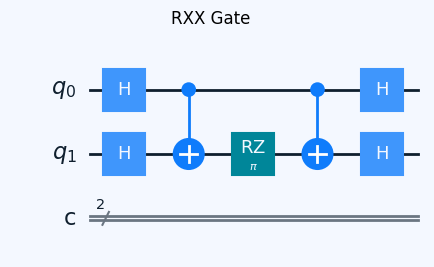

In [28]:
fig = qulib.draw(gate=RXX(3.141592654), num_qubits=(1, 1), output="mpl")
fig.suptitle("RXX Gate")
fig

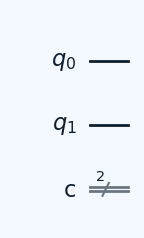

In [29]:
def porta_rxx(theta: float, qubits: Quant):
    # Implemente a portas RXX(ϴ)
    ...


qulib.draw(gate=porta_rxx, num_qubits=(2,), args=(3.141592654,), output="mpl")

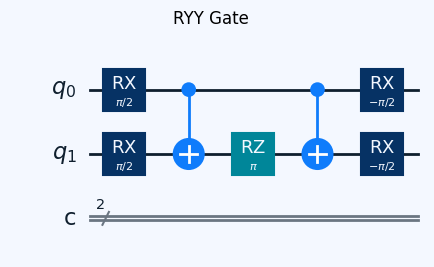

In [30]:
fig = qulib.draw(gate=RYY(3.141592654, None, None), num_qubits=(1, 1), output="mpl")
fig.suptitle("RYY Gate")
fig

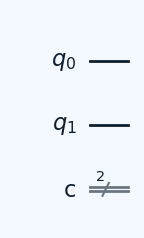

In [31]:
def porta_ryy(theta: float, qubits: Quant):
    # Implemente a portas RYY(ϴ)
    ...


qulib.draw(gate=porta_ryy, num_qubits=(2,), args=(3.141592654,), output="mpl")

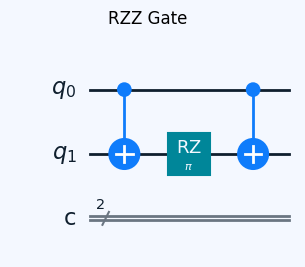

In [32]:
fig = qulib.draw(gate=RZZ(3.141592654, None, None), num_qubits=(1, 1), output="mpl")
fig.suptitle("RZZ Gate")
fig

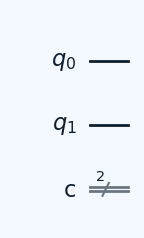

In [33]:
def porta_rzz(theta: float, qubits: Quant):
    # Implemente a portas RZZ(ϴ)
    ...


qulib.draw(gate=porta_rzz, num_qubits=(2,), args=(3.141592654,), output="mpl")

## Medidas

Após realizar os cálculos na computação quântica, é necessário extrair os resultados para o ambiente clássico. Isso é feito por meio de medidas nos qubits. Nesta seção, exploraremos diferentes formas de medir qubits no Ket.

### Extrair o Estado Quântico

Ao simularmos um computador quântico, como fazemos neste capítulo, não estamos restritos às limitações da mecânica quântica. Assim, podemos extrair todo o estado quântico do simulador para manipulá-lo dentro do Python. Para isso, utilizamos a função {func}`~ket.operations.dump`, que retorna uma instância de {class}`~ket.base.QuantumState`.

Com o objeto {class}`~ket.base.QuantumState`, é possível iterar sobre o estado quântico usando o atributo {attr}`~ket.base.QuantumState.states`. Neste atributo, o estado quântico é representado por um dicionário que mapeia o estado da base, representado por um número inteiro ({class}`int`), para sua amplitude de probabilidade associada, representada por um número complexo ({class}`complex`).

:::{warning}
A extração do {class}`~ket.base.QuantumState` só é possível quando estamos em um ambiente simulado. Além disso, o {class}`~ket.base.QuantumState` não tem a capacidade de representar estados mistos. Portanto, se o {class}`~ket.base.QuantumState` representar um qubit entrelaçado com um qubit que não pertence ao mesmo {class}`~ket.base.QuantumState`, a representação não será completa.

Tendo isso em mente, o uso da função {func}`~ket.operations.dump` é uma ótima maneira de testar e debugar uma execução quântica. No entanto, não é recomendado substituir uma medida por esta abordagem.
:::

Além do atributo {attr}`~ket.base.QuantumState.states`, é possível acessar o atributo {attr}`~ket.base.QuantumState.probabilities` para obter as probabilidades de medida. Também podemos utilizar o método {meth}`~ket.base.QuantumState.sample` para simular uma amostragem a partir do {class}`~ket.base.QuantumState`.

Abaixo, seguem exemplos de como utilizar a função {func}`~ket.operations.dump` para extrair o estado quântico e iterar sobre ele através do atributo {attr}`~ket.base.QuantumState.states`.

In [34]:
processo = Process()

qubits = processo.alloc(2)

# prepara estado de Bell
cat(kron(H, I), CNOT)(*qubits)

estado_quântico = dump(qubits)

for estado, amplitude in estado_quântico.states.items():
    print(f"{amplitude} |{estado}⟩")

(0.7071067811865476+0j) |0⟩
(0.7071067811865476+0j) |3⟩


Uma maneira alternativa de exibir o estado quântico é utilizando o método {meth}`~ket.base.QuantumState.show` da classe {class}`~ket.base.QuantumState`.

In [35]:
estado_quântico.show()

<IPython.core.display.Math object>

### Medição de Qubits

A função {func}`~ket.operations.measure` é utilizada para medir qubits na base computacional, resultando em um objeto do tipo {class}`~ket.base.Measurement`. Após a medição, o estado do qubit colapsa para o estado correspondente à medida realizada. Para extrair o resultado da medida, basta acessar o atributo {attr}`~ket.base.Measurement.value`, o qual retorna um número inteiro sem sinal. É importante observar que o qubit de índice 0 corresponde ao bit de maior magnitude no resultado final. Portanto, a medição dos qubits $\ket{\texttt{xyz}}$ resulta no número binário $\texttt{0b}\texttt{xyz}$.

Abaixo está um exemplo de uso da função {func}`~ket.operations.measure`. Neste exemplo, estamos medindo o primeiro qubit após a preparação do estado de Bell e exibindo o resultado da medida.

In [36]:
processo = Process()

qubits = processo.alloc(2)

# Preparando o estado de Bell
cat(kron(H, I), CNOT)(*qubits)

print("Estado quântico antes da medida")
display(dump(qubits).show())

medida = measure(qubits[0])
print("Resultado da medida do primeiro qubit:", medida.value)

print("Estado quântico após o colapso")
display(dump(qubits).show())

Estado quântico antes da medida


<IPython.core.display.Math object>

Resultado da medida do primeiro qubit: 0
Estado quântico após o colapso


<IPython.core.display.Math object>

#### Exercício: Medidas em Outras Bases

Os computadores quânticos normalmente realizam medidas apenas na base computacional (base Z). No entanto, aplicando algumas operações quânticas, é possível realizar medidas em outras bases. Neste exercício, exploraremos medidas nas bases X e Y.

**Medidas na Base X (Hadamard):**

Na base X, também conhecida como base de Hadamard, a medida de um qubit no estado $\frac{1}{\sqrt{2}}(\ket{0}+\ket{1})$ retorna 0, e a medida no estado $\frac{1}{\sqrt{2}}(\ket{0}-\ket{1})$ retorna 1. Implemente as rotações necessárias nos qubits para efetuar uma medida na base computacional usando a função {func}`~ket.operations.measure`.



In [37]:
def medir_x(qubit: Quant) -> int: ...


def verificar_medir_x():
    processo = Process()

    a, b = processo.alloc(2)
    X(b)
    H(a + b)

    assert medir_x(a) == 0
    assert medir_x(b) == 1
    print("Verificação concluída com sucesso")


# verificar_medir_x()

**Medidas na Base Y:**

Na base Y, a medida de um qubit no estado $\frac{1}{\sqrt{2}}(\ket{0}+i\ket{1})$ retorna 0, e a medida no estado $\frac{1}{\sqrt{2}}(\ket{0}-i\ket{1})$ retorna 1. Implemente as rotações necessárias nos qubits para efetuar uma medida na base computacional usando a função {func}`~ket.operations.measure`.

In [38]:
def medir_y(qubit: Quant) -> int: ...


def verificar_medir_y():
    processo = Process()

    a, b = processo.alloc(2)
    X(b)
    S(H(a + b))

    assert medir_y(a) == 0
    assert medir_y(b) == 1
    print("Verificação concluída com sucesso")


# verificar_medir_y()

### Amostragem de Qubits

Muitos algoritmos quânticos dependem não apenas de uma medida exata, mas de uma distribuição de probabilidades. Portanto, é necessário executar várias medições em vez de apenas uma. Muitos computadores quânticos implementam esse comportamento, e o Ket oferece a função {func}`~ket.operations.sample`, que retorna uma instância de {class}`~ket.base.Samples` com os resultados das medições. Para acessar o resultado, basta ler o atributo {attr}`~ket.base.Samples.value`, que retorna um dicionário mapeando o estado medido ao número de vezes que esse estado foi observado.

:::{attention}
Nos simuladores padrão do Ket o estado quântico não é colapsado após a chamada da função {func}`~ket.operations.sample`, e os qubits permanecem disponíveis para outras operações. No entanto, esse comportamento não é garantido em computadores quânticos reais, onde os qubits normalmente se tornam indisponíveis após a medição.
:::

A seguir, apresentamos um exemplo de uso da função {func}`~ket.operations.sample`:

In [39]:
processo = Process()

qubits = processo.alloc(2)

# Preparando o estado de Bell
cat(kron(H, I), CNOT)(*qubits)

estado_quântico = dump(qubits)

print("Estado quântico")
display(dump(qubits).show('i'))

medida = sample(qubits)
print("Resultado das medidas:", medida.value)

Estado quântico


<IPython.core.display.Math object>

Resultado das medidas: {0: 1023, 3: 1025}



### Calcular Valor Esperado

## Execução Quântica e Simulação    

### Modos de Execução Quântica

### Configuração do Processo e dos Simuladores